## Evaluation Script

In [75]:
import sys
import matplotlib.pyplot as plt
import json
import numpy as np
from os import listdir
from os.path import isfile, join

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)


# check whether tx is tp, tn, fp, fn and add tx to associated array


def confusionTest(arr,tp, tn_left, tn_right, fp, fn, constraintIntervalStartTime, endTime):

    count_tp = 0
    count_tn_left = 0
    count_tn_right = 0
    count_fp = 0
    count_fn = 0

    for i in range(len(arr)):
        if(arr[i]["initialTimestamp"] <= constraintIntervalStartTime and arr[i]["result"] == "-1"):
            count_tn_left += 1
        if (arr[i]["initialTimestamp"] >= endTime and arr[i]["result"] == "-1"):
            count_tn_right += 1
        if(arr[i]["initialTimestamp"] < constraintIntervalStartTime and arr[i]["result"] == "1" or arr[i]["initialTimestamp"] > endTime and arr[i]["result"] == "1"):
            count_fp += 1
        if(arr[i]["initialTimestamp"] > constraintIntervalStartTime and arr[i]["initialTimestamp"] < endTime and arr[i]["result"] == "1"):
            count_tp += 1
        if(arr[i]["initialTimestamp"] > constraintIntervalStartTime and arr[i]["initialTimestamp"] < endTime and arr[i]["result"] == "-1"):
            count_fn += 1

    tp.append(count_tp)
    tn_left.append(count_tn_left)
    tn_right.append(count_tn_right)
    fp.append(count_fp)
    fn.append(count_fn)
    
    return (tp, tn_left, tn_right, fp, fn)

# calculates the accuracy for one batch of transactions (1s) and appends the result to the accuracy array

def calculateWindowAccuracy(arr,accuracy, constraintIntervalStartTime, endTime):
    windowAccuracy = 0
    successes = 0
    numOfTransactions = len(arr)
    for i in range(len(arr)):

        if(arr[i]["initialTimestamp"] > constraintIntervalStartTime and arr[i]["initialTimestamp"] < endTime and arr[i]["result"] == "1" or (arr[i]["initialTimestamp"] < constraintIntervalStartTime or arr[i]["initialTimestamp"] > endTime) and arr[i]["result"] == "-1"):
            successes = successes + 1

    if numOfTransactions > 0:
        windowAccuracy = successes / numOfTransactions
    else:
        windowAccuracy = 1.0

    accuracy.append(windowAccuracy)
    return accuracy


## loop through each transactions and check whether transaction is tp, tn, fp ,fn and create accuracy array

def evaluate(root):
    
    # store start and end time of constraint interval in milliseconds
    constraintIntervalStartTime = root["constraintIntervalStartTime"] * 1000
    constraintIntervalDuration = int(root["constraintIntervalDuration"])*1000
    endTime = constraintIntervalStartTime + constraintIntervalDuration 
    experimentStart = (constraintIntervalStartTime-preceedingTimeInMs)
    transactions = root["transactions"]
    transactionRate = int(root["transactionRate"])


    timeInSeconds = 0.0
    blockTimestamps = []
    blockTimestamps.append(int(transactions[0]["blockTimestamp"]))
    batch_txs = []
    
    tp = []
    tn_left = []
    tn_right = []
    fp = []
    fn = []
    accuracy = []


    ## Loops through all transactions and bundles them to batches defined by the window size. Calculates the accuracy of the current batch
    
    for tx in transactions:
      
        if tx is not None:
            if(tx["initialTimestamp"] > endTime + constraintIntervalDuration):
                continue
            if (tx["initialTimestamp"] - experimentStart) / 1000 >= timeInSeconds +1.0 :
                timeInSeconds = timeInSeconds + 1.0
                ## calculate accuracy of current batch
                accuracy = calculateWindowAccuracy(batch_txs,accuracy, constraintIntervalStartTime, endTime)
                ## do the confusion test
                (tp, tn_left, tn_right, fp, fn) = confusionTest(batch_txs, tp, tn_left, tn_right, fp, fn, constraintIntervalStartTime, endTime)
                batch_txs = []
            if(int(tx["blockTimestamp"]) - blockTimestamps[-1] > 0):
                blockTimestamps.append(int(tx["blockTimestamp"]))
            batch_txs.append(tx)
            
    (tp, tn_left, tn_right, fp, fn) = confusionTest(batch_txs, tp, tn_left, tn_right, fp, fn, constraintIntervalStartTime, endTime)
    accuracy = calculateWindowAccuracy(batch_txs,accuracy, constraintIntervalStartTime, endTime)

    return (accuracy, tp,tn_left, tn_right, fp, fn, blockTimestamps, experimentStart,constraintIntervalDuration, transactionRate)


# draws a bi-directional arrow between the lower and upper bound of the constraint interval

def indicate_acitiviness_of_smart_contract(ax, constraintIntervalDurationInS, height=5, ):
    ax.axvline(x=preceedingTimeInS, ls="--", color="black")
    ax.axvline(x=preceedingTimeInS+constraintIntervalDurationInS, ls="--", color="black")
    arrowLength = constraintIntervalDurationInS-constraintIntervalDurationInS*0.05
    arrowHeadWidth = 2.5
    arrowHeadLength = constraintIntervalDurationInS*0.05
    ax.arrow(preceedingTimeInS, 103, arrowLength, 0, head_width=arrowHeadWidth, head_length=arrowHeadLength, color="black")
    ax.arrow(preceedingTimeInS+constraintIntervalDurationInS, 103, -arrowLength, 0, head_width=arrowHeadWidth, head_length=arrowHeadLength, color="black")
    ax.text(preceedingTimeInS + constraintIntervalDurationInS/2, 105, "constraint interval", horizontalalignment="center", fontsize="28")


### Single Experiment Accuracy Plot

In [76]:
preceedingTimeInMs = 15000
preceedingTimeInS = preceedingTimeInMs /1000 

path = "./generatedData/goerli/60/1/1649440246190.json"
with open(path, 'r') as json_file:
    root = json.load(json_file)
    (accuracy, tp,tn_left, tn_right, fp, fn, blockTimestamps,experimentStart, constraintIntervalDuration, transactionRate) = evaluate(root)
    tp = np.round(tp,2)
    fp = np.round(fp,2)
    fn = np.round(fn,2)
    tn_left = np.round(tn_left,2)
    tn_right = np.round(tn_right,2)
    
    fig, ax = plt.subplots()
    time = np.arange(0, len(accuracy), 1)
    ax.plot(time, accuracy)
    ax.set_xticks(np.arange(0,len(accuracy)+15,15))
    ax.set_ylabel("accuracy")
    ax.set_xlabel("time in s")
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlim([-0.5,len(accuracy) + 0.5])
    ax.set_ylim([0,1])

    fig.savefig("plot1_ganache.svg")


FileNotFoundError: [Errno 2] No such file or directory: './generatedData/goerli/60/1/1649440246190.json'

### Single Experiment Confusion Plot

In [77]:
preceedingTimeInMs = 15000
preceedingTimeInS = preceedingTimeInMs /1000 

path = "./generatedData/goerli/60/1/1649440246190.json"
with open(path, 'r') as json_file:
    root = json.load(json_file)
    (accuracy, tp,tn_left, tn_right, fp, fn, blockTimestamps,experimentStart, constraintIntervalDuration, transactionRate) = evaluate(root)
    tp = np.round(tp,2)
    fp = np.round(fp,2)
    fn = np.round(fn,2)
    tn_left = np.round(tn_left,2)
    tn_right = np.round(tn_right,2)
    fig, ax = plt.subplots()
    
    time = np.arange(0, len(accuracy), 1)
    indicate_acitiviness_of_smart_contract(ax,constraintIntervalDuration)
    tn = np.add(np.array(tn_left), np.array(tn_right))
    
    allData = np.add(tp, tn)
    allData = np.add(allData, fn)
    allData = np.add(allData, fp)


    ax.bar(time, 100*tp/transactionRate, align="edge", label="tp", color="black", alpha=0.15)
    ax.bar(time, 100*tn/transactionRate, align="edge", label="tn", color="black", alpha=0.3)
    ax.bar(time, 100*fp/transactionRate, align="edge", label="fp", color="black", alpha=0.6, bottom=100*fn/transactionRate)
    ax.bar(time, 100*fn/transactionRate, align="edge", label="fn", color="black", alpha=1,  bottom=100*fp/transactionRate)
    ax.legend()

    ax.set_xticks(np.arange(0,len(accuracy)+15,15))
    ax.set_ylabel("transactions in %")
    ax.set_xlabel("time in s")
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_xlim([-0.5,len(accuracy) + 0.5])

    fig.savefig("plot2_custom.svg")



FileNotFoundError: [Errno 2] No such file or directory: './generatedData/goerli/60/1/1649440246190.json'

### Aggregated Experiments Plots

In [78]:

def aggregateData(network, cid, transactionRate, b=""):

    files = []
    ## configure the path to the directory where the experiment data resides
    
    path = "./generatedData/" + network + "/" + str(b) +  "/" + str(cid) + "/" + str(transactionRate) + "/"

            
    [files.append(f) for f in listdir(path) if isfile(join(path, f))]
    numOfFiles = len(files)
    current_f = path + files[0]
    
    with open(current_f, 'r') as json_file:
        root = json.load(json_file)
        (accuracy, tp,tn_left, tn_right, fp, fn, blockTimestamps,experimentStart, constraintIntervalDuration, transactionRate) = evaluate(root)
        aggregatedAccurcay = np.array(accuracy)
        aggregatedTP = tp
        aggregatedTN_left = tn_left
        aggregatedTN_right = tn_right
        aggregatedFP = fp
        aggregatedFN = fn
    
    for i in range(numOfFiles-1):

        current_f = path + files[i+1]
        with open(current_f, 'r') as json_file:
            root = json.load(json_file)
            (accuracy, tp,tn_left, tn_right, fp, fn, blockTimestamps,experimentStart, constraintIntervalDuration, transactionRate) = evaluate(root)
         
            aggregatedAccurcay = np.add(aggregatedAccurcay ,accuracy)
            aggregatedTP = np.add(aggregatedTP ,tp)
            aggregatedFP = np.add(aggregatedFP ,fp)
            aggregatedFN = np.add(aggregatedFN ,fn)
            aggregatedTN_left = np.add(aggregatedTN_left ,tn_left)
            aggregatedTN_right = np.add(aggregatedTN_right ,tn_right)


    # calculate I_FP and I_FN for current offsets (d)       
    
    I_fp_current = 0
    I_fn_current = 0

    for x in aggregatedFP:
        if x>0:
            I_fp_current = I_fp_current +1
            
    for x in aggregatedFN:
        if x>0:
             I_fn_current = I_fn_current +1
            
  
    aggregatedAccurcay = np.round(aggregatedAccurcay/numOfFiles,2)

    aggregatedTP = np.round(aggregatedTP/numOfFiles,2)
    aggregatedFP = np.round(aggregatedFP/numOfFiles,2)
    aggregatedFN = np.round(aggregatedFN/numOfFiles,2)
    aggregatedTN_right = np.round(aggregatedTN_right/numOfFiles,2)
    aggregatedTN_left = np.round(aggregatedTN_left/numOfFiles,2)

    
    return (aggregatedTP, aggregatedTN_left, aggregatedTN_right, aggregatedFN, aggregatedFP, aggregatedAccurcay, blockTimestamps, experimentStart, constraintIntervalDuration, transactionRate)

### Aggregated Confusion Plot

### 2. Rinkeby and Goerli simulated (if no experiment data is available)

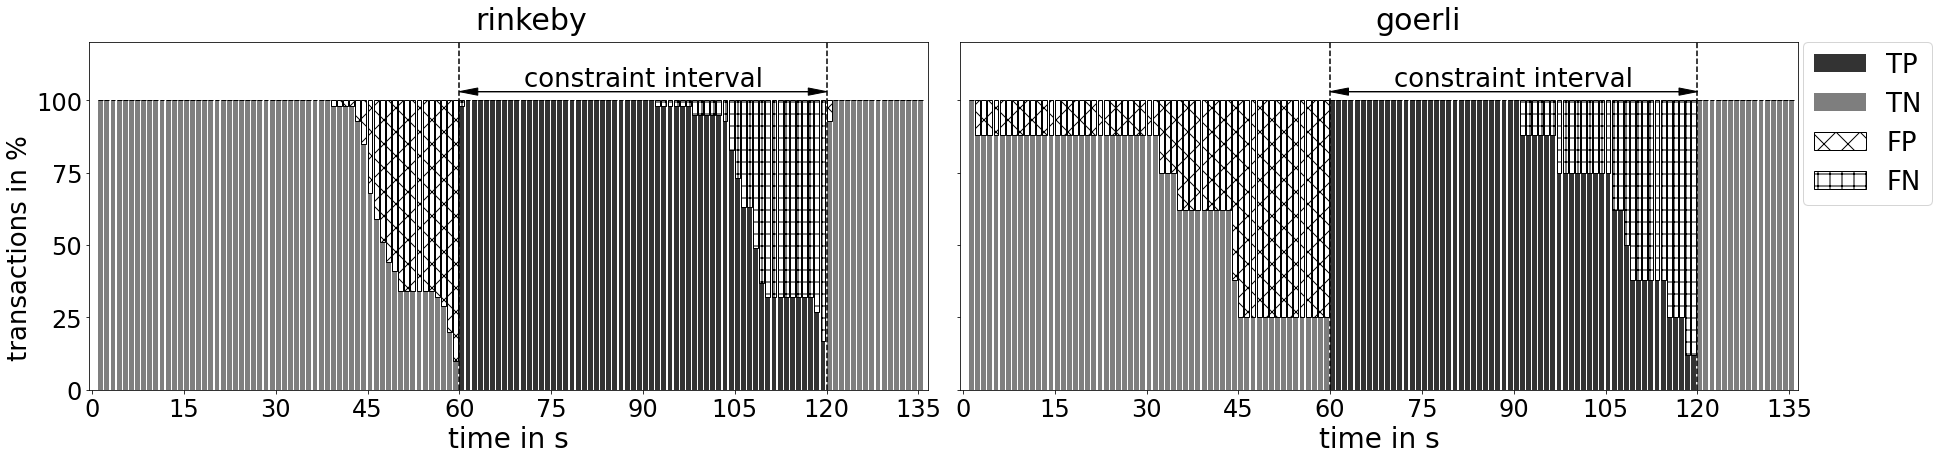

In [86]:
rinkebyData = {"aggregatedTP": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.98,0.98,0.98,0.98,0.98,0.95,0.95,0.95,0.95,0.95,0.93,0.83,0.73,0.63,0.63,0.49,0.37,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.27,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], "aggregatedTN": [0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.98,0.98,0.98,0.98,0.93,0.85,0.68,0.59,0.51,0.44,0.41,0.34,0.34,0.34,0.34,0.34,0.34,0.32,0.29,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
], "aggregatedFN": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.02,0.02,0.02,0.02,0.05,0.05,0.05,0.05,0.05,0.07,0.17,0.27,0.37,0.37,0.51,0.63,0.68,0.68,0.68,0.68,0.68,0.68,0.68,0.68,0.73,0.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], "aggregatedFP": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.02,0.02,0.02,0.07,0.15,0.32,0.41,0.49,0.56,0.59,0.66,0.66,0.66,0.66,0.66,0.66,0.68,0.71,0.8,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
]}

goerliData = {"aggregatedTP": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.88,0.88,0.88,0.88,0.88,0.88,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.62,0.62,0.5,0.38,0.38,0.38,0.38,0.38,0.38,0.25,0.25,0.25,0.12,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], "aggregatedTN": [0.0,1.0,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.88,0.75,0.75,0.75,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.62,0.38,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0], "aggregatedFN": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12,0.12,0.12,0.12,0.12,0.12,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.38,0.38,0.5,0.62,0.62,0.62,0.62,0.62,0.62,0.75,0.75,0.75,0.88,0.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
], "aggregatedFP": [0.0,0.0,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.25,0.25,0.25,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.62,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
]}

preceedingTimeInMs = 60000
preceedingTimeInS = preceedingTimeInMs /1000 

transactionRate = 1
constraintIntervalDuration = 60

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (25,6))#, gridspec_kw={'height_ratios': [height_ratio, height_ratio-2, 0.9]})#, constrained_layout = True)

time = np.arange(0, len(rinkebyData["aggregatedTP"]), 1)
indicate_acitiviness_of_smart_contract(ax1,constraintIntervalDuration)

fig.text(0.25, 1.025, 'rinkeby', va='center', fontsize=30)
ax1.bar(time, 100*np.array(rinkebyData["aggregatedTP"])/transactionRate, align="edge", label="TP", color="black", alpha=0.8)
ax1.bar(time, 100*np.array(rinkebyData["aggregatedTN"])/transactionRate, align="edge", label="TP", color="black", alpha=0.5)
ax1.bar(time, 100*np.array(rinkebyData["aggregatedFP"])/transactionRate, align="edge", label="TP", color="black", bottom=100*np.array(rinkebyData["aggregatedTN"])/transactionRate, fill=False, hatch="x")
ax1.bar(time, 100*np.array(rinkebyData["aggregatedFN"])/transactionRate, align="edge", label="TP", color="black" , bottom=100*np.array(rinkebyData["aggregatedTP"])/transactionRate, fill=False, hatch="+")


ax1.set_xticks(np.arange(0,len(time)+15,15))
ax1.set_xlabel("time in s", fontsize="28")
ax1.set_xlim([-0.5,len(time) + 0.5])

ax1.tick_params(axis="x", labelsize="24")
ax1.tick_params(axis="y", labelsize="24")


ax1.set_yticks([0, 25, 50, 75, 100])
ax1.set_ylim([0, 120])

fig.text(0.75, 1.025, 'goerli', va='center', fontsize=30)
ax2.bar(time, 100*np.array(goerliData["aggregatedTP"])/transactionRate, align="edge", label="TP", color="black", alpha=0.8)
ax2.bar(time, 100*np.array(goerliData["aggregatedTN"])/transactionRate, align="edge", label="TN", color="black", alpha=0.5)
ax2.bar(time, 100*np.array(goerliData["aggregatedFP"])/transactionRate, align="edge", label="FP", color="black", bottom=100*np.array(goerliData["aggregatedTN"]), fill=False, hatch="x")
ax2.bar(time, 100*np.array(goerliData["aggregatedFN"])/transactionRate, align="edge", label="FN", color="black" , bottom=100*np.array(goerliData["aggregatedTP"]), fill=False, hatch="+")


ax2.set_xticks(np.arange(0,len(time)+15,15))
ax2.set_xlabel("time in s", fontsize="28")
ax2.set_xlim([-0.5,len(time) + 0.5])

ax2.tick_params(axis="x", labelsize="24")
ax2.tick_params(axis="y", labelsize="24")

ax2.set_yticks([0, 25, 50, 75, 100])
ax2.set_ylim([0, 120])
indicate_acitiviness_of_smart_contract(ax2,constraintIntervalDuration)


yLabel = fig.text(-0.01, 0.5, 'transactions in %', va='center', rotation='vertical', fontsize=26)
fig.tight_layout()
lgd = ax2.legend(loc='upper right', bbox_to_anchor=(1.175,1.04),prop={'size': 26})

### 2. Rinkeby and Goerli

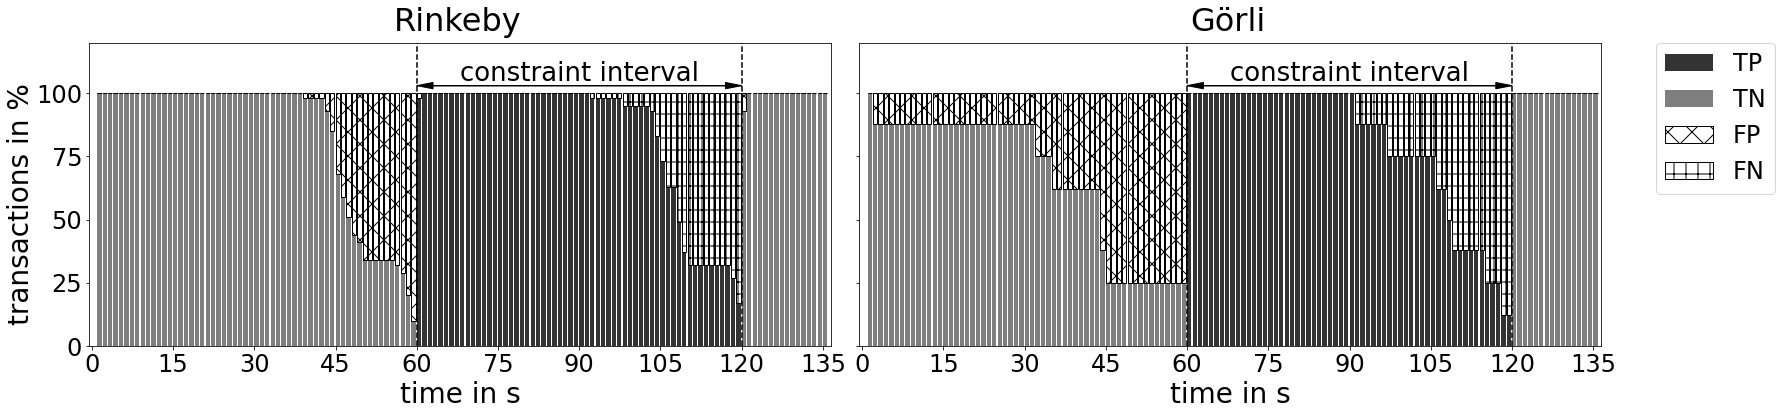

In [97]:
networks = ["rinkeby", "görli"]
constraintIntervalDurations = [60]
preceedingTimeInMs = 60000
preceedingTimeInS = preceedingTimeInMs /1000 

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (25,6))#, gridspec_kw={'height_ratios': [height_ratio, height_ratio-2, 0.9]})#, constrained_layout = True)

axes = [ax1,ax2]
axIndex = 0
for network in networks:
    for cid in constraintIntervalDurations:
        ax = axes[axIndex]
        # loop through all configruations and aggregate the result from the experiment 
        (aggregatedTP, aggregatedTN_left, aggregatedTN_right, aggregatedFN, aggregatedFP, aggregatedAccurcay, blockTimestamps, experimentStart, constraintIntervalDuration, transactionRate) = aggregateData(network, cid, 1)
        time = np.arange(0, len(aggregatedAccurcay), 1)
        indicate_acitiviness_of_smart_contract(ax,cid)
        aggregatedTN = np.add(aggregatedTN_left, aggregatedTN_right)
 
        ax.bar(time, 100*aggregatedTP/transactionRate, align="edge", label="TP", color="black", alpha=0.8)
        ax.bar(time, 100*aggregatedTN/transactionRate, align="edge", label="TN", color="black", alpha=0.5)
        ax.bar(time, 100*aggregatedFP/transactionRate, align="edge", label="FP", color="black", bottom=100*aggregatedTN/transactionRate, fill=False, hatch="x")
        ax.bar(time, 100*aggregatedFN/transactionRate, align="edge", label="FN", color="black", bottom=100*aggregatedTP/transactionRate, fill=False, hatch="+")

        ax.set_xticks(np.arange(0,len(time)+15,15))
        ax.set_xlabel("time in s", fontsize="28")
        ax.set_xlim([-0.5,len(aggregatedTN) + 0.5])

        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_ylim([0, 120])
        
        ax.tick_params(axis="x", labelsize="24")
        ax.tick_params(axis="y", labelsize="24")

        axIndex+= 1

        networkName = ax.text(67.5,128, network.capitalize(), ha='center', va='center', fontsize=32)#, rotation='vertical')

yLabel = fig.text(-0.01, 0.5, 'transactions in %', va='center', rotation='vertical', fontsize=28)
lgd = ax2.legend(loc='upper right', bbox_to_anchor=(1.25,1.04),prop={'size': 24})
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.tight_layout()

fig.savefig("rinkeby_goerli.pdf", bbox_extra_artists=(lgd,networkName,yLabel,) , bbox_inches='tight')

end
end


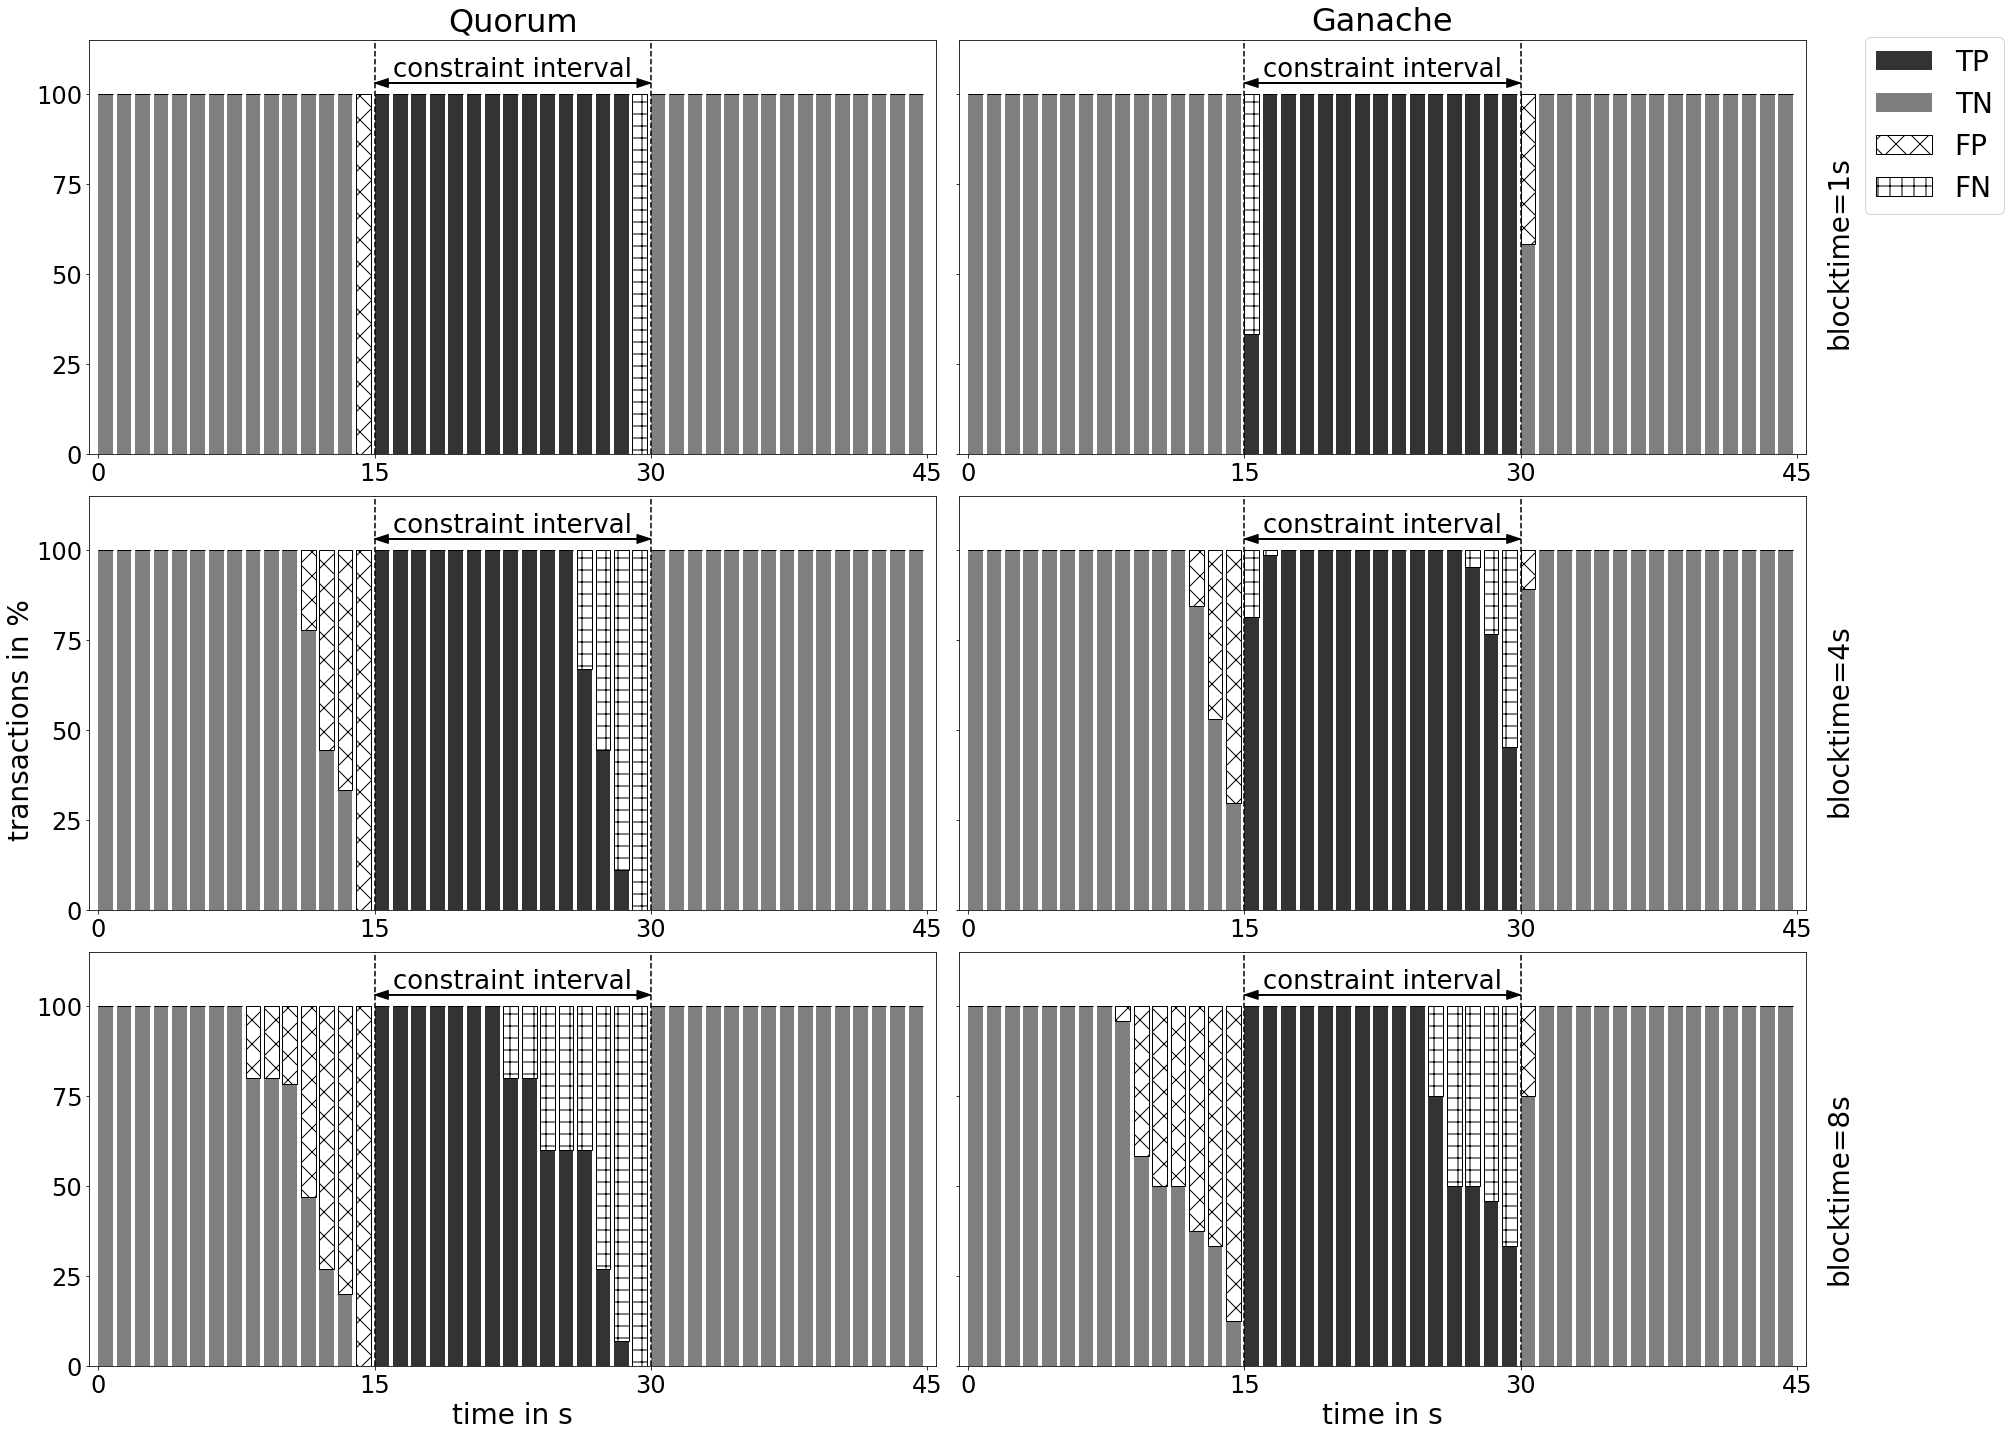

In [94]:
networks = ["quorum", "ganache"]
constraintIntervalDurations = [15]
transactionRate = 4

preceedingTimeInMs = 15000
preceedingTimeInS = preceedingTimeInMs /1000 

fig, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3, 2, sharey=True, figsize = (25,20))#, gridspec_kw={'height_ratios': [height_ratio, height_ratio-2, 0.9]})#, constrained_layout = True)
axes = [ax1,ax2, ax3, ax4, ax5, ax6]
blocktimes = [1, 4, 8]
axIndex = 0

for cid in constraintIntervalDurations:
    for b in blocktimes:
        for network in networks:
            ax = axes[axIndex]
            # loop through all configruations and aggregate the result from the experiment 
            (aggregatedTP, aggregatedTN_left, aggregatedTN_right, aggregatedFN, aggregatedFP, aggregatedAccurcay, blockTimestamps, experimentStart, constraintIntervalDuration, transactionRate) = aggregateData(network, cid, transactionRate, b)

            time = np.arange(0, len(aggregatedAccurcay), 1)
            indicate_acitiviness_of_smart_contract(ax,cid)
            aggregatedTN = np.add(aggregatedTN_left, aggregatedTN_right)
            aggregatedTN[0] = 4
            atp = aggregatedTP
            ax.bar(time, 100*aggregatedTP/transactionRate, align="edge", label="TP", color="black", alpha=0.8)
            ax.bar(time, 100*aggregatedTN/transactionRate, align="edge", label="TN", color="black", alpha=0.5)
            ax.bar(time, 100*aggregatedFP/transactionRate, align="edge", label="FP", color="black", bottom=100*aggregatedTN/transactionRate, fill=False, hatch="x")
            ax.bar(time, 100*aggregatedFN/transactionRate, align="edge", label="FN", color="black", bottom=100*aggregatedTP/transactionRate, fill=False, hatch="+")

            ax.set_xticks(np.arange(0,len(aggregatedTN)+15,15))
            if axIndex>3 :
                ax.set_xlabel("time in s", fontsize=28)
            elif axIndex <2:
                networkName = ax.text(22.5,120, network.capitalize(), ha='center', va='center', fontsize=32)#, rotation='vertical')
            else:
                print("end")
    

            ax.set_yticks([0, 25, 50, 75, 100])
            ax.set_xlim([-0.5,len(aggregatedTN) + 0.5])
            ax.set_ylim([0, 115])
            ax.tick_params(axis="x", labelsize="24")
            ax.tick_params(axis="y", labelsize="24")
          
            axIndex+= 1
yLabel = fig.text(-0.01, 0.5, 'transactions in %', va='center', rotation='vertical', fontsize=28)
fig.text(1, 0.825, 'blocktime=1s', va='center', rotation='vertical', fontsize=28)
fig.text(1, 0.5, 'blocktime=4s', va='center', rotation='vertical', fontsize=28)
fig.text(1, 0.175, 'blocktime=8s', va='center', rotation='vertical', fontsize=28)


fig.tight_layout()
lgd = ax2.legend(loc='upper right', bbox_to_anchor=(1.25,1.04),prop={'size': 28})

fig.savefig("ganache_custom.pdf", bbox_extra_artists=(lgd,networkName, yLabel,), bbox_inches='tight')